In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense,Reshape,Dropout,BatchNormalization,Flatten,Input,Conv2D,Conv2DTranspose,LeakyReLU,Dropout,Embedding,concatenate 
from IPython import display


In [5]:
#get the dataset
(x_train,_),_ = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype(np.float32)/255.0

4431872/4422102 [==============================] - 0s 0us/step


In [6]:
#define parameters
LATENT_DIM = 64
BATCH_SIZE = 64

In [7]:
#convert to tf dataset
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(3000)
dataset = dataset.batch(BATCH_SIZE,drop_remainder = True).prefetch(1)

In [17]:
#define generator model
def generator():
  model = tf.keras.Sequential()
  model.add(Dense(7*7,input_shape=[LATENT_DIM]))
  model.add(LeakyReLU(0.1))
  
  model.add(Reshape([7,7,1]))
  model.add(Conv2DTranspose(128,(4,4),padding='same',strides=(2,2)))
  model.add(LeakyReLU(0.2))
  
  model.add(Conv2DTranspose(1,(4,4),padding='same',activation="sigmoid",strides=(2,2)))
  model.add((BatchNormalization()))
  #model.add(LeakyReLU(0.2))
 
  
  return model

gen = generator()
gen.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 49)                3185      
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 49)                0         
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 1)           0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 14, 14, 128)      2176      
 ranspose)                                                       
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 28, 28, 1)        2049      
 ranspose)                                            

In [18]:
#define discriminator model
def discriminator():
  model = tf.keras.Sequential()
  model.add(Conv2D(128,(4,4),strides=(2,2),padding="same",input_shape = [28,28,1]))
  model.add(LeakyReLU(0.2))
  
  model.add(Conv2D(64,(4,4),strides=(2,2),padding="valid"))
  model.add(LeakyReLU(0.2))
  
  model.add(Flatten())
  model.add(Dense(64))
  model.add(LeakyReLU(0.2))
  model.add((BatchNormalization()))
  model.add(Dense(1,activation="sigmoid"))
  return model

dis = discriminator()
dis.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 14, 14, 128)       2176      
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 6, 6, 64)          131136    
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 6, 6, 64)          0         
                                                                 
 flatten_2 (Flatten)         (None, 2304)              0         
                                                                 
 dense_7 (Dense)             (None, 64)                147520    
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 64)               

In [19]:
#define composite model
dis = discriminator()
gen = generator()
gan = tf.keras.Sequential([gen,dis])
dis.compile(loss="binary_crossentropy",optimizer="Adam")
dis.trainable = False
gan.compile(loss="binary_crossentropy",optimizer="Adam")

In [20]:
#train
def train(gan,dataset,num_epochs):
  gen,dis = gan.layers
  for epoch in range(num_epochs):
    print(epoch)
    for real_image_batch in dataset:
      #draw latent vectors
      latent = tf.random.normal([BATCH_SIZE,LATENT_DIM])
      #get the fake batch
      fake_image_batch = tf.squeeze(gen(latent))
      #create input to discriminator
      x_concat = tf.concat([real_image_batch,fake_image_batch],axis=0)
      y_concat = tf.concat([tf.convert_to_tensor(np.ones(BATCH_SIZE)),tf.convert_to_tensor(np.zeros(BATCH_SIZE))],axis=0)
      #train discriminator
      dis.trainable = True
      dis.train_on_batch(x_concat,y_concat)
      #fix discriminator weights
      dis.trainable = False
      #draw latent vectors again
      latent = tf.random.normal([BATCH_SIZE,LATENT_DIM])
      #labels for gen training
      y = tf.convert_to_tensor(np.ones(BATCH_SIZE))
      #train the generator
      gan.train_on_batch(latent, y)

In [24]:
train(gan,dataset,50)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


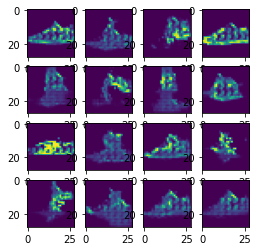

In [25]:
def plot(images):
  #enter a square num of images
  num = np.sqrt(len(images))
  plt.figure(figsize=(num,num))
  for index, image in enumerate(images):
    plt.subplot(num,num,index+1)
    plt.imshow(image[:,:,0])

latent = tf.random.normal([16,LATENT_DIM])
gen = gan.layers[0]
plot(gen(latent))

In [26]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [27]:
gan.save("/content/drive/MyDrive/convGAN_FashionMNIST")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/convGAN_FashionMNIST/assets
